# Rheological analysis of polystyrene creep mastercurve
 
This notebook performs a rheological analysis of polystyrene at various temp times, using logarithmic transformations, shift factors, master curve construction, and rheological modeling. The data is from Isaac Miranda-Valdez's archive.

We import:
- `pandas` for reading and manipulating data.
- `numpy` for mathematical computations like logarithmic transformations.
- `matplotlib.pyplot` for detailed visualizations.
- `re` for regex operations to extract temperatemps  information from filenames.
- `mastercurves` and `pyRheo` for master curve construction and model fitting.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from mastercurves import MasterCurve
from mastercurves.transforms import Multiply
from pyRheo.creep_model import CreepModel


# Load and inspect rheological data
This cell loads experimental data from a CSV file containing:
- Time (`time`) in [rad/s].
- Creep Compliance (`J_creep`) in [1/Pa].

The data is loaded using `pandas` and the first few rows are displayed for verification.


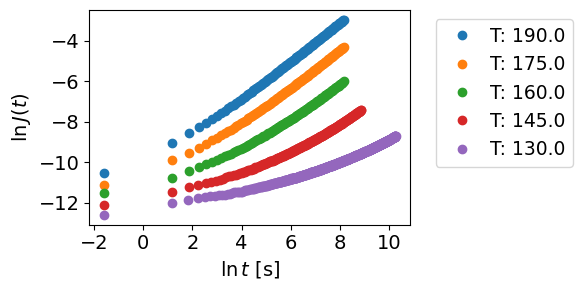

In [2]:
# List of files containing data at various temps. In time domain, long times mean high temperatures, so we start with high temp files
filenames = [
    './data/polystyrene/creep_ps190_data.csv',
    './data/polystyrene/creep_ps175_data.csv',
    './data/polystyrene/creep_ps160_data.csv',
    './data/polystyrene/creep_ps145_data.csv',
    './data/polystyrene/creep_ps130_data.csv',
]

# Define column names and initialize lists for storing data
columns = ['Time', 'Creep Compliance']
time_log_list, J_creep_log_list, temp_list = [], [], []

# Initialize figure for visualization
plt.figure(figsize=(6, 3))

# Loop through files to process data
for filename in filenames:
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
    data.columns = columns
    
    # Log-transform Time and moduli
    log_interval_time = np.log(data['Time'][::30]) # Downsampling because GPR is slow with big datasets
    log_creep_modulus = np.log(data['Creep Compliance'][::30])

    # Append the log-transformed data to the lists[i]
    time_log_list.append(np.array(log_interval_time))
    J_creep_log_list.append(np.array(log_creep_modulus))

    # Extract temp from filename
    match = re.search(r'ps(\d+)_data\.csv$', filename)
    if match:
        temp = float(match.group(1))
        temp_list.append(temp)
        plt.plot(log_interval_time, log_creep_modulus, 'o', label=f'T: {temp}')
    else:
        print(f"Warning: No temps found in filename {filename}")

# Finalize the plot
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\ln t$ [s]', fontsize=14)
plt.ylabel(r'$\ln J(t)$', fontsize=14)
plt.legend(fontsize=13.5, handletextpad=0.5, ncol=1, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


# Construct master curve
1. Use the `MasterCurve` class to build a master curve for the data.
2. Horizontal and vertical transformations are applied using logarithmic scaling.
3. Superposition is performed to align the datasets.
4. The shift factors for aligning the data are extracted.


/m/scicomp/software/anaconda-ci/aalto-ubuntu2004-anaconda/software/anaconda/2023-04/e0d50272/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


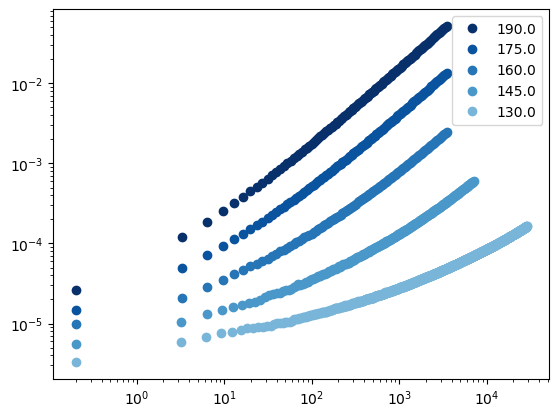

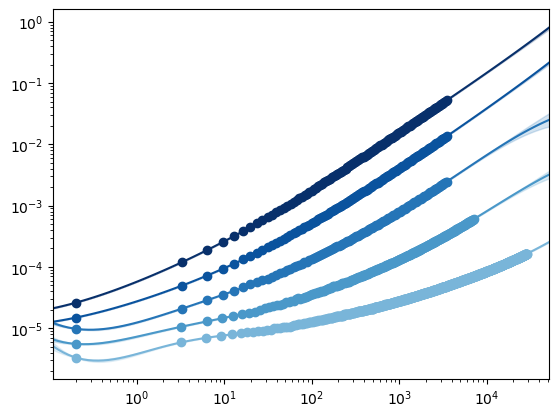

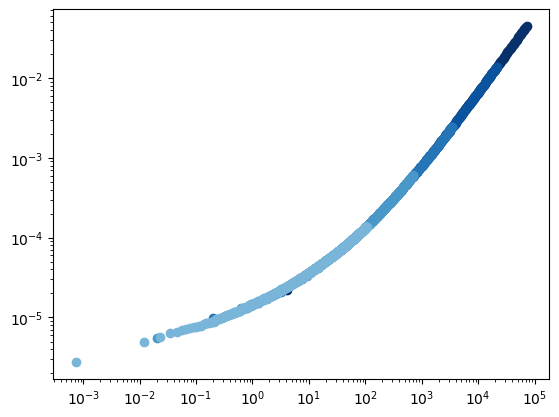

In [3]:
# Build a master curve using the MasterCurve library
mc = MasterCurve()
mc.add_data(time_log_list, J_creep_log_list, temp_list)

# Adjust GPR kernel. Due to the data size, it will take time to compute the GPR. Consider downsampling
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
kernel = (ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-10, 1e3)) * 
          RBF(length_scale=[1], length_scale_bounds=(1e-10, 1e3)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e2)))
mc.set_gp_kernel(kernel)

# Apply logarithmic transformations for horizontal and vertical shifts
mc.add_htransform(Multiply(scale="log")) # natural log
mc.add_vtransform(Multiply(scale="log")) # natural log

# Perform superposition
mc.superpose()

# Change reference temp
mc.change_ref(160)

# Plot the master curve and extract shift factors
fig1, ax1, fig2, ax2, fig3, ax3 = mc.plot(colormap=lambda i: plt.cm.Blues_r(i / 1.5))
hshift_factors = [np.array(np.log(factor)) for factor in mc.hparams[0]]
vshift_factors = [np.array(np.log(factor)) for factor in mc.vparams[0]]


# Plot shift factors as a function of temp


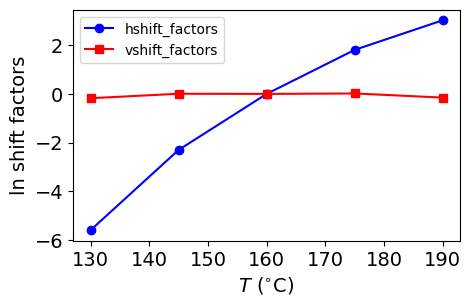

In [4]:
# Create the plot
plt.figure(figsize=(5, 3))

# Plot both factors
plt.plot(temp_list, hshift_factors, label="hshift_factors", marker='o', color='blue')
plt.plot(temp_list, vshift_factors, label="vshift_factors", marker='s', color='red')

# Add labels and title
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$T$ ($^{\circ}$C)', fontsize=14)
plt.ylabel('ln shift factors', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Apply shift factors to data
1. Shift factors are used to align all datasets onto a single master curve.
2. Log-transformed data is shifted and converted back to the original scale.
3. The combined Time and moduli values are stored for further analysis.


In [5]:
shifted_time, shifted_J_creep = [], []

for idx, (time_log, J_creep_log) in enumerate(zip(time_log_list, J_creep_log_list)):
    # Apply shift factors
    shifted_time_log = time_log + hshift_factors[idx]
    shifted_J_creep_log = J_creep_log + vshift_factors[idx]

    # Convert back to linear scale and append
    shifted_time = np.concatenate([shifted_time, np.exp(shifted_time_log)])    
    shifted_J_creep = np.concatenate([shifted_J_creep, np.exp(shifted_J_creep_log)])
    

# Organize and visualize shifted data
1. Create a DataFrame from the shifted Time and moduli arrays.
2. Clean the data by removing NaN values.
3. Reorder the DataFrame by shear rate for consistent visualization.
4. Plot the shifted data to validate the alignment from the master curve transformation.


       Time  Creep Compliance
0  0.000738          0.000003
1  0.011760          0.000005
2  0.020057          0.000006
3  0.022822          0.000006
4  0.033929          0.000006


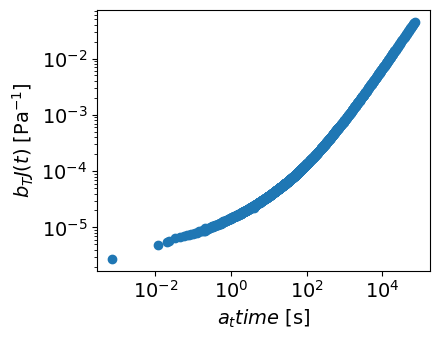

In [6]:
# Create a DataFrame from shifted Time and moduli arrays
df = pd.DataFrame({'Time': shifted_time, 'Creep Compliance': shifted_J_creep})

# Clean NaNs
df_cleaned = df.dropna()

# Reorder the DataFrame by 'Time' from minimum to maximum
df_sorted = df_cleaned.sort_values(by='Time', ascending=True).reset_index(drop=True)

# Show the DataFrame (optional)
print(df_sorted.head())

# Plot
plt.figure(figsize=(4.5, 3.5))
plt.plot(shifted_time, shifted_J_creep, "o")

# Customize the plot
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$a_{t} time$ [s]', fontsize=14)
plt.ylabel(r'$b_{T}J(t)$ [Pa$^{-1}$]', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()


# Fit model to master curve with pyRheo

1. The master curve data (oscillation and moduli) is used for model fitting.
2. The `pyRheo` library is employed to fit a FractionalZenerLiquidD model.
3. The model parameters, fitting error, and predictions are displayed.


Predicted Model: FractionalMaxwell
Best initial guess was: [1138661.188361854, 815398.8280641177, 0.5588869227595015, 0.1085732733720043]
G: 80134.17975113186
V: 1036945.7007418274
alpha: 0.9531027749373723
beta: 0.291129131006596
RSS: 0.8089184026236804
Mean Percentage Error: 1.42%


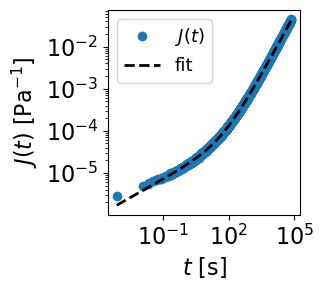

In [7]:
# Load master curve data
time_mc = df_sorted['Time'].values
J_creep_mc = df_sorted['Creep Compliance'].values


# Model fitting
model = CreepModel(model="auto", initial_guesses="random", num_initial_guesses=10, minimization_algorithm="Powell",
                           mittag_leffler_type="Pade72"
                       )
model.fit(time_mc, J_creep_mc)

model.print_parameters()
model.print_error()
model.plot(time_mc, J_creep_mc, savefig=False)

# Plot the master curve with colors and fitted prediction
1. Use the previously calculated horizontal (`hshift_factors`) and vertical (`vshift_factors`) shift factors to align data from multiple datasets.
2. Load the datasets and apply transformations to Time and moduli using the shift factors.
3. Generate a color-coded plot for each dataset showing the aligned data.
4. Overlay the master curve prediction from the fitted model for comparison.
5. Customize the plot with labels, scales, and legends, and save the final visualization.


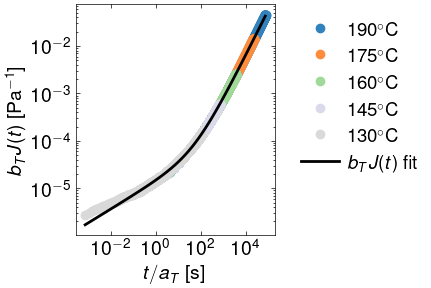

In [8]:
# Import packages for plotting
import matplotlib as mpl
from matplotlib.ticker import LogLocator
import scienceplots

# Ensure the 'scienceplots' style is used for better visualization
plt.style.use(['science', 'nature', 'bright'])

# Plot master curve labeled with the model prediction
time_predict = np.logspace(np.min(np.log10(time_mc)), np.max(np.log10(time_mc)), 100)
J_creep_predict = model.predict(time_predict)


# List of files to process
sorted_filenames = [
    './data/polystyrene/creep_ps190_data.csv',
    './data/polystyrene/creep_ps175_data.csv',
    './data/polystyrene/creep_ps160_data.csv',
    './data/polystyrene/creep_ps145_data.csv',
    './data/polystyrene/creep_ps130_data.csv',
]


num_files = len(sorted_filenames)

# Adjusted size for better visibility of multiple plots
plt.figure(figsize=(4.5, 3.0))

# Labels for each temp data
labels = [
    "190$^\circ$C", "175$^\circ$C", "160$^\circ$C", "145$^\circ$C",
    "130$^\circ$C"
]

# Get the colormap (this returns a continuous colormap)
colormap = mpl.colormaps['tab20c']

# Convert it to a discrete colormap with 'num_files' colors
colors = colormap(np.linspace(0, 1, num_files))

# Store legend handles for different temps
temp_handles = []

# Plot data
for i, filename in enumerate(sorted_filenames):
    # Load the data from the CSV file
    data = pd.read_csv(filename, decimal='.', encoding='utf-8', sep='\t')
    data.columns = columns

    # Extract and log-transform the 'Time', 'Creep Compliance', and 'Loss Modulus' columns
    log_interval_time = np.log(data['Time'])
    log_J_creep = np.log(data['Creep Compliance'])

    # Apply shift factor
    log_interval_time_shifted = log_interval_time + hshift_factors[i]
    log_interval_J_creep_shifted = log_J_creep + vshift_factors[i]

    # Get label and color
    label = labels[i]
    color = colors[i % len(colors)]

    # Plot data with shifts applied
    plt.plot(np.exp(log_interval_time_shifted), np.exp(log_interval_J_creep_shifted), 'o', 
             color=color, markersize=6, alpha=1, label=label)

    
# Plot master curve fit
plt.plot(time_predict, J_creep_predict, '-', color="k", lw=2, label='$b_{T}J(t)$ fit')


# Customize the plot
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$t/a_{T} $ [s]', fontsize=14)
plt.ylabel(r'$b_{T}J(t)$ [Pa$^{-1}$]', fontsize=14)
plt.legend(fontsize=13.5, loc='upper left', handletextpad=0.5, bbox_to_anchor=(1.05, 1))
plt.grid(False)
plt.tight_layout()

# Display the plot
plt.show()
